# How to use CORE API as your data provider in common TDM tasks


# A small CORE API client 

Nothing like a full CORE API client like the one for java that covers all the functionalities of CORE API (https://github.com/oacore/oacore4j). Yet, is a simple wrapper, essentially a class that crafts URLs and with the use of urllib fetches the content of that URL

Keep an eye in http://github.com/oacore more clients / modules / bundles for other programming languages coming up.

In [14]:
from urllib2 import urlopen
from urllib import urlencode
from urllib import quote_plus
from urllib import quote
# import urllib.parse
import json
import pprint

class CoreApiClient:

    def __init__(self, endpoint, api_key):
        self.endpoint = endpoint
        self.api_key = api_key
        #defaults
        self.pagesize = 100
        self.page = 1

    def parse_response(self, decoded):
        res = []
        for item in decoded['data']:
            doi = None
            if 'identifiers' in item:
                for identifier in item['identifiers']:
                    if identifier and identifier.startswith('doi:'):
                        doi = identifier
                        break
            res.append([item['title'], doi])
        return res

    def request_url(self, url):
        response = urlopen(url)
        html = response.read()
        return html

    def get_method_query_request_url(self,method,query,fullText,page):
        if (fullText):
            fullText = 'true'
        else:
            fullText = 'false'
        params = {
            'apiKey':self.api_key,
            'page':page,
            'pageSize':self.pagesize,
            'fulltext':fullText
        }
        return self.endpoint + method + '/' + quote_plus(query) + '?' + urlencode(params)

    def get_up_to_20_pages_of_query(self,method,query,fulltext):
        url = self.get_method_query_request_url(method,query,fulltext,1)
        all_articles=[]
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        all_articles.append(result)
        if (result['totalHits']>100):
            numOfPages = int(result['totalHits']/self.pagesize)  #rounds down
            if (numOfPages>20):
                numOfPages=20
            for i in range(2,numOfPages):
                url = self.get_method_query_request_url(method,query,False,i)
                print(url)
                resp =self.request_url(url)
                all_articles.append(json.loads(resp.decode('utf-8')))
        return all_articles
    
    def get_repository_articles_fulltext_as_dict(self,repository_id):
        return ""
    
    def get_search_repository_request_url(self,repoQuery,page=1,pageSize=10):
        params={
            'apiKey':self.api_key,
            'page':page,
            'pageSize':pageSize
        }
        return self.endpoint + "/repositories/search/"+quote_plus(repoQuery)+'?'+urlencode(params)
    
    def search_repository_ids_by_name(self,repoName):
        discoverRepoUrl = self.get_search_repository_request_url(repoName)
        resp = self.request_url(discoverRepoUrl)
        result = json.loads(resp.decode('utf-8'))
        for item in result['data']:
            if 'name' in item:
                name = item['name']
            if 'id' in item:
                id = item['id']
            repos[id]=name
        return repos
    
    def get_count_articles_of_repository_url(self,repoId,withFullText):
        ft = 'false'
        if(withFullText):
            ft = 'true'
                
        params = {
            'apiKey':self.api_key,
            'fulltext':ft
        }    
        return self.endpoint + "/articles/search/repositories.id:"+repoId+'?'+urlencode(params)
    
    def count_articles_of_repository(self,repoId,withFullText=False):
        countArticlesOfRepoUrl = self.get_count_articles_of_repository_url(repoId,withFullText)
        print(countArticlesOfRepoUrl)
        resp = self.request_url(countArticlesOfRepoUrl)
        result = json.loads(resp.decode('utf-8'))
        return result['totalHits']
    
    def get_url_of_download_articles_of_repository(self,repoId,fullText,page,pageSize):
        params={
            'apiKey':self.api_key,
            'page':page,
            'pageSize':pageSize,
            'fulltext':fullText
               }
        return self.endpoint + "/articles/search/repositories.id:"+str(repoId)+'?'+urlencode(params)
    
    def download_articles_of_repository(self, repoId, fulltext=True, page=1, pageSize=100):
        url = self.get_url_of_download_articles_of_repository(repoId,fulltext,page,pageSize)
        all_articles=[]
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        if (result['totalHits']>100):
            numOfPages = int(result['totalHits']/self.pagesize)  #rounds down
            if (numOfPages>5):
                numOfPages=5
            for i in range(2,numOfPages):
                url = self.get_url_of_download_articles_of_repository(repoId,fulltext,page,pageSize)
                print(url)
                resp =self.request_url(url)
                all_articles.append(json.loads(resp.decode('utf-8')))
        return all_articles
    
    def get_core_article_by_id(self,core_id,fulltext=False):
        ft='false'
        if (fulltext):
            ft='true'
        params={
            'apiKey':self.api_key,
            'fulltext':ft
        }
        url = self.endpoint + '/articles/get/'+str(core_id)+'?'+urlencode(params)
        print(url)
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        if (result['data']):
            return result['data']
        else:
            return ""
        return ""
    
    def get_core_article_by_doi(self,doi,fulltext=False):
        ft='false'
        if (fulltext):
            ft='true'
        query = "\""+doi+"\""
        params={
            'apiKey':self.api_key,
            'fulltext':ft
        }
        url = self.endpoint + '/articles/search/doi:'+quote(query)+'?'+urlencode(params)
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        if (result['totalHits']>=1):
            return result['data'][0]
        else:
            return ""
        

## Register your api key

Here: https://core.ac.uk/api-keys/register

It takes literally 2 min

.. and that if you are slow


## Explore CORE API

https://core.ac.uk/services#api

Play with the live console (swagger/openAPI)

https://core.ac.uk/docs/

### Play with CORE API from this notebook

In [30]:
'''
Initialise parameters
'''
# init 
endpoint = 'https://core.ac.uk/api-v2'

'''
********************************************
Add your own api key below
'''
api_key =""
# or get it from a config file
file = open("api_key.secret","r") 
api_key=file.read()
api_key=api_key.strip()
'''
********************************************
'''
'''
Create your api object
'''
api = CoreApiClient(endpoint,api_key)


In [206]:
print (api.get_core_article_by_id(42,True))

https://core.ac.uk/api-v2/articles/get/42?fulltext=true&apiKey=btYj73TKGQahoUzL41yHANnJVeClvPIX
{u'fullText': u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006). Applying Systemic Project Management Approaches for the\nUK National Health Service. Systemic Practice and Action Research, 19(1), pp. 27\u201343.\nFor guidance on citations see FAQs.\nc\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners. For more information on Open Research Online\u2019s data policy on reuse of materials please consult\nthe policies page.\noro.open.ac.uk\n 1\nApplying Systemic

In [207]:
'''
Fetch an article by DOI
'''

doi="10.1016/j.nuclphysb.2015.11.012"
print(api.get_core_article_by_doi(doi,True))

{u'fullText': u'a\nr\nX\ni\nv\n:\n1\n0\n0\n7\n.\n1\n7\n7\n0\nv\n1\n \n \n[\nh\ne\np\n-\nt\nh\n]\n \n \n1\n1\n \nJ\nu\nl\n \n2\n0\n1\n0\nPreprint typeset in JHEP style - HYPER VERSION LPT ENS-10/25\nFinite Size Spectrum of SU(N) Principal Chiral Field\nfrom Discrete Hirota Dynamics\nVladimir Kazakov\u2217 and S\xb4 ebastien Leurent\nEcole Normale Superieure, LPT, 75231 Paris CEDEX-5, France &\nl\u2019Universit\xb4 e Paris-VI, Paris, France;\nE-mail: Vladimir.Kazakov\u2022ens.fr, Sebastien.Leurent\u2022ens.fr\nAbstract: Using recently proposed method of discrete Hirota dynamics for integrable\n(1+1)D quantum \ufb01eld theories on a \ufb01nite space circle of length L we derive and test\nnumerically a \ufb01nite system of nonlinear integral equations for the exact spectrum of energies\nof SU(N) \xd7 SU(N) principal chiral \ufb01eld model as functions of mL, where m is the mass\nscale. We propose a determinant solution of the underlying Y-system, or Hirota equation,\nin terms of determinan

In [209]:
'''
Fetch an article by core ID
'''
id=42
#just metadata
api.get_core_article_by_id(id)

https://core.ac.uk/api-v2/articles/get/42?fulltext=false&apiKey=btYj73TKGQahoUzL41yHANnJVeClvPIX


{u'authors': [u'Bell, Simon', u'Christina, Ann'],
 u'contributors': [],
 u'datePublished': u'2006-02',
 u'description': u'This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward',
 u'fulltextIdentifier': u'https://core.ac.uk/download/pdf/42.pdf',
 u'id': u'42',
 u'identifiers': [u'oai:open.ac.uk.OAI2:108', None],
 u'language': {u'code': u'en', u'id': 9, u'name': u'English'},
 u'oai': u'oai:open.ac.uk.OAI2:

In [6]:
#with full text
api.get_core_article_by_id(id,True)

https://core.ac.uk/api-v2/articles/get/42?fulltext=true&apiKey=20hIsS1F5j4D2C2iXrg4Wxf7VTp4Xt1j


{u'authors': [u'Bell, Simon', u'Christina, Ann'],
 u'contributors': [],
 u'datePublished': u'2006-02',
 u'description': u'This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward',
 u'fullText': u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Articl

# Now, let's do some NLP

In [210]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/mc26486/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
'''
In case you don;t have nltk - uncomment and run
'''
!pip install nltk
import nltk

  Using cached nltk-3.2.4.tar.gz
  Running setup.py bdist_wheel for nltk ... - \ | / - \ | / - \ | / - done
  Stored in directory: /Users/mc26486/Library/Caches/pip/wheels/79/8b/2a/b2da7fce57a1fd9b20b08fa8800c83b6fde62af9e880722e29
Successfully built nltk


In [22]:
from nltk.probability import FreqDist
from nltk.corpus import treebank
'''
in case any of the above complains, you need to download the corresponding corpora by executing:
nltk.download()
'''


'\nin case any of the above complains, you need to download the corresponding corpora by executing:\nnltk.download()\n'

In [23]:
articleText = api.get_core_article_by_id(42,True)['fullText']
articleText

https://core.ac.uk/api-v2/articles/get/42?fulltext=true&apiKey=btYj73TKGQahoUzL41yHANnJVeClvPIX


u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006). Applying Systemic Project Management Approaches for the\nUK National Health Service. Systemic Practice and Action Research, 19(1), pp. 27\u201343.\nFor guidance on citations see FAQs.\nc\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners. For more information on Open Research Online\u2019s data policy on reuse of materials please consult\nthe policies page.\noro.open.ac.uk\n 1\nApplying Systemic Project Management Approaches for the \nUK National Health Service1 \n \nDr. Simon Bell Ann Christina \nOpen 

## Sentence segmentation

In [24]:
'''
Let's split the text into sentences:
'''
sentences = nltk.sent_tokenize(articleText)
sentences

[u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006).',
 u'Applying Systemic Project Management Approaches for the\nUK National Health Service.',
 u'Systemic Practice and Action Research, 19(1), pp.',
 u'27\u201343.',
 u'For guidance on citations see FAQs.',
 u'c\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners.',
 u'For more information on Open Research Online\u2019s data policy on reuse of materials please consult\nthe policies page.',
 u'oro.open.ac.uk\n 1\nApplying Systemic Project Management Approaches for the \nUK National Health Service1 \n \nDr.

In [25]:
import pprint
pprint.pprint(sentences)

[u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006).',
 u'Applying Systemic Project Management Approaches for the\nUK National Health Service.',
 u'Systemic Practice and Action Research, 19(1), pp.',
 u'27\u201343.',
 u'For guidance on citations see FAQs.',
 u'c\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners.',
 u'For more information on Open Research Online\u2019s data policy on reuse of materials please consult\nthe policies page.',
 u'oro.open.ac.uk\n 1\nApplying Systemic Project Management Approaches for the \nUK National Health Service1 \n \nDr.

In [26]:
'''
Couldn't we just split(".") ??
'''
wrong_sentences = articleText.split(".")
len(wrong_sentences)

396

In [27]:
len(sentences)

327

In [28]:
'''
Aparently not, e.g. see this sentence
'''
sentences[5]

u'c\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners.'

In [29]:
sentences[5].split(".")

[u'c\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx',
 u'doi',
 u'org/doi:10',
 u'1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners',
 u'']

It incorrectly breaks down to more than one (5) sentences.

Let's break further to tokens (words):

In [30]:
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
tokenized_sentences[1:100]

[[u'Applying',
  u'Systemic',
  u'Project',
  u'Management',
  u'Approaches',
  u'for',
  u'the',
  u'UK',
  u'National',
  u'Health',
  u'Service',
  u'.'],
 [u'Systemic',
  u'Practice',
  u'and',
  u'Action',
  u'Research',
  u',',
  u'19',
  u'(',
  u'1',
  u')',
  u',',
  u'pp',
  u'.'],
 [u'27\u201343', u'.'],
 [u'For', u'guidance', u'on', u'citations', u'see', u'FAQs', u'.'],
 [u'c\xa9',
  u'[',
  u'not',
  u'recorded',
  u']',
  u'Version',
  u':',
  u'[',
  u'not',
  u'recorded',
  u']',
  u'Link',
  u'(',
  u's',
  u')',
  u'to',
  u'article',
  u'on',
  u'publisher',
  u'\u2019',
  u's',
  u'website',
  u':',
  u'http',
  u':',
  u'//dx.doi.org/doi:10.1007/s11213-005-9002-4',
  u'Copyright',
  u'and',
  u'Moral',
  u'Rights',
  u'for',
  u'the',
  u'articles',
  u'on',
  u'this',
  u'site',
  u'are',
  u'retained',
  u'by',
  u'the',
  u'individual',
  u'authors',
  u'and/or',
  u'other',
  u'copy-',
  u'right',
  u'owners',
  u'.'],
 [u'For',
  u'more',
  u'information',
  u

## Part of speech tagging (POS tagging):

In [31]:
pos_tagged_0 = nltk.pos_tag(tokenized_sentences[0])
pprint.pprint(sentences[0])
pprint.pprint(tokenized_sentences[0])
pprint.pprint(pos_tagged_0)

u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006).'
[u'Open',
 u'Research',
 u'Online',
 u'The',
 u'Open',
 u'University',
 u'\u2019',
 u's',
 u'repository',
 u'of',
 u'research',
 u'publications',
 u'and',
 u'other',
 u'research',
 u'outputs',
 u'Applying',
 u'Systemic',
 u'Project',
 u'Management',
 u'Approaches',
 u'for',
 u'the',
 u'UK',
 u'National',
 u'Health',
 u'Service',
 u'Journal',
 u'Article',
 u'How',
 u'to',
 u'cite',
 u':',
 u'Bell',
 u',',
 u'Simon',
 u'and',
 u'Christina',
 u',',
 u'Ann',
 u'(',
 u'2006',
 u')',
 u'.']
[(u'Open', 'JJ'),
 (u'Research', 'NNP'),
 (u'Online', 'NNP'),
 (u'The', 'DT'),
 (u'Open', 'NNP'),
 (u'University', 'NNP'),
 (u'\u2019', 'NNP'),
 (u's', 'VBD'),
 (u'repository', 'NN'),
 (u'of', 'IN'),
 (u'research', 'NN'),
 (u'publications

What does the label mean next to each token ?
1. NN -> noun (plural)
2. NNP -> noun (singular)
3. VB -> Verb
4. CC -> conjuction
5. ,,,,


A full list of each label can be found here: http://www.comp.leeds.ac.uk/amalgam/tagsets/upenn.html

## NER Named Entity Recognition

In [32]:
parse_tree = nltk.ne_chunk(nltk.tag.pos_tag(sentences[1].split()), binary=True)
named_entities = []

for t in parse_tree.subtrees():
    if t.label() == 'NE':
#         named_entities.append(t)
        named_entities.append(list(t))  # if you want to save a list of tagged words instead of a tree

pprint.pprint(named_entities)

[[(u'Systemic', 'NNP'), (u'Project', 'NNP')],
 [(u'UK', 'NNP'), (u'National', 'NNP'), (u'Health', 'NNP')]]


In [33]:
## DBPedia spotlight
## TextRazor 
## for more "semantic" labels

In [34]:
## DBPedia spotlight:
'''
Get the article abstract
'''
articleAbstract=api.get_core_article_by_id(42,True)['description']
articleAbstract

https://core.ac.uk/api-v2/articles/get/42?fulltext=true&apiKey=btYj73TKGQahoUzL41yHANnJVeClvPIX


u'This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward'

In [35]:
url = "http://model.dbpedia-spotlight.org/en/annotate?text="+quote_plus(articleAbstract)
response = urlopen(url)
r_text = response.read()
from IPython.core.display import HTML
HTML(r_text)

In [36]:
'''
The same as above but printing XML nice'''

import lxml.etree as etree

x = etree.fromstring(r_text)
print(etree.tostring(x, pretty_print = True))


<html xmlns="http://www.w3.org/1999/xhtml" xmlns:lexvo="http://lexvo.org/ontology#" xmlns:dbpedia="http://dbpedia.org/resource/" xmlns:dbpo="http://dbpedia.org/ontology/">
<head>
<title>DBpedia Spotlight annotation</title>
</head>
<body>
<div>
This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the <a about="http://dbpedia.org/resource/National_Health_Service" href="http://dbpedia.org/resource/National_Health_Service" title="http://dbpedia.org/resource/National_Health_Service" target="_blank">National Health Service</a> (<a about="http://dbpedia.org/resource/National_Health_Service" href="http://dbpedia.org/resource/National_Health_Service" title="http://dbpedia.org/resource/National_Health_Service" target="_blank">NHS</a>) in <a about="http://dbpedia.org/resource/Staffordshire" typeof="http://dbpedia.org/ontology/AdministrativeRegion" href="http://dbpedia.org/resource/Staffordshire" title="htt

## Text razor

#### Again a NER/analyze text - maps to freebase entities - gives back a confidence score


In [37]:
!pip install textrazor
import textrazor

  Running setup.py bdist_wheel for textrazor ... - done
  Stored in directory: /Users/mc26486/Library/Caches/pip/wheels/cf/d1/ff/927548addc592735a3991427e3ea4d3b8e3841cdc4cf3dfe13
Successfully built textrazor


In [38]:
#personal API key - just for this demo - please do not use anywhere else
textrazor.api_key = "eba9d80209aaad9627277d21437d2e0f56ef9c1e6e16332f221af063"

client = textrazor.TextRazor(extractors=["entities", "topics"])
response = client.analyze(articleAbstract)

for entity in response.entities():
    print entity.id, entity.relevance_score, entity.confidence_score, entity.freebase_types

Health 0.3637 1.185 [u'/media_common/quotation_subject', u'/business/industry', u'/organization/organization_sector', u'/media_common/literary_genre', u'/internet/website_category', u'/education/field_of_study', u'/radio/radio_subject', u'/broadcast/genre', u'/media_common/media_genre', u'/exhibitions/exhibition_subject', u'/internet/blog', u'/business/product_category', u'/organization/organization_type', u'/book/book_subject', u'/book/periodical_subject']
Research 0.6039 1.194 [u'/architecture/building_function', u'/education/school_category', u'/book/periodical_subject', u'/spaceflight/satellite_type', u'/media_common/quotation_subject', u'/book/book_subject', u'/business/industry', u'/organization/organization_sector', u'/architecture/building_complex_function', u'/organization/organization_type', u'/education/field_of_study', u'/award/award_discipline']
National Health Service 0.351 3.016 []
Staffordshire 0.1787 3.334 [u'/location/statistical_region', u'/location/location', u'/per

## Stemming

In [39]:
from nltk.stem import PorterStemmer

In [40]:
stemmer = PorterStemmer()

In [41]:
stemmer.stem("Management")


u'manag'

In [42]:
stemmer.stem("Manager")

u'manag'

In [43]:
stemmer.stem("Managerial")

u'manageri'

In [44]:
for token in tokenized_sentences[0]:
    pprint.pprint(token+' '+stemmer.stem(token))

u'Open open'
u'Research research'
u'Online onlin'
u'The the'
u'Open open'
u'University univers'
u'\u2019 \u2019'
u's s'
u'repository repositori'
u'of of'
u'research research'
u'publications public'
u'and and'
u'other other'
u'research research'
u'outputs output'
u'Applying appli'
u'Systemic system'
u'Project project'
u'Management manag'
u'Approaches approach'
u'for for'
u'the the'
u'UK UK'
u'National nation'
u'Health health'
u'Service servic'
u'Journal journal'
u'Article articl'
u'How how'
u'to to'
u'cite cite'
u': :'
u'Bell bell'
u', ,'
u'Simon simon'
u'and and'
u'Christina christina'
u', ,'
u'Ann ann'
u'( ('
u'2006 2006'
u') )'
u'. .'


What if I don't do English?


In [45]:
from nltk.stem import SnowballStemmer
SnowballStemmer.languages

(u'danish',
 u'dutch',
 u'english',
 u'finnish',
 u'french',
 u'german',
 u'hungarian',
 u'italian',
 u'norwegian',
 u'porter',
 u'portuguese',
 u'romanian',
 u'russian',
 u'spanish',
 u'swedish')

## Lemmatization

Like stemming but not exactly - more like synonym replacement

In [46]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('paper')

'paper'

In [47]:
lemmatizer.lemmatize('buses')

u'bus'

In [48]:
for token in tokenized_sentences[0]:
    pprint.pprint(token+' '+lemmatizer.lemmatize(token))

u'Open Open'
u'Research Research'
u'Online Online'
u'The The'
u'Open Open'
u'University University'
u'\u2019 \u2019'
u's s'
u'repository repository'
u'of of'
u'research research'
u'publications publication'
u'and and'
u'other other'
u'research research'
u'outputs output'
u'Applying Applying'
u'Systemic Systemic'
u'Project Project'
u'Management Management'
u'Approaches Approaches'
u'for for'
u'the the'
u'UK UK'
u'National National'
u'Health Health'
u'Service Service'
u'Journal Journal'
u'Article Article'
u'How How'
u'to to'
u'cite cite'
u': :'
u'Bell Bell'
u', ,'
u'Simon Simon'
u'and and'
u'Christina Christina'
u', ,'
u'Ann Ann'
u'( ('
u'2006 2006'
u') )'
u'. .'


Pretty much the same, or maybe not ??

In [49]:
'''printing all the words that lemma is different than the word'''
for tokenized_sentence in tokenized_sentences:
    for token in tokenized_sentence:
        ltoken = lemmatizer.lemmatize(token)
        stoken=stemmer.stem(token)
        if (ltoken!=token):
            pprint.pprint(token+' '+ltoken)


u'publications publication'
u'outputs output'
u'citations citation'
u'articles article'
u'authors author'
u'owners owner'
u'materials material'
u'policies policy'
u'sets set'
u'observations observation'
u'methods method'
u'projects project'
u'sets set'
u'reasons reason'
u'approaches approach'
u'methodologies methodology'
u'outcomes outcome'
u'reflections reflection'
u'workshops workshop'
u'conclusions conclusion'
u'authors author'
u'results result'
u'methods method'
u'professionals professional'
u'strengths strength'
u'workforces workforce'
u'experiences experience'
u'approaches approach'
u'was wa'
u'was wa'
u'boundaries boundary'
u'sets set'
u'notes note'
u'methods method'
u'professionals professional'
u'needs need'
u'reflections reflection'
u'systems system'
u'methods method'
u'as a'
u'means mean'
u'issues issue'
u'situations situation'
u'aspects aspect'
u'its it'
u'issues issue'
u'as a'
u'hundreds hundred'
u'employers employer'
u'organisations organisation'
u'challenges challenge'
u

So is like stemming, or maybe not

In [50]:
'''Printing all the words that stemming is different than the lemma'''
for tokenized_sentence in tokenized_sentences:
    for token in tokenized_sentence:
        ltoken = lemmatizer.lemmatize(token)
        stoken=stemmer.stem(token)
        if (ltoken!=stoken):
            pprint.pprint(token+' '+stoken+' '+ltoken)

u'Open open Open'
u'Research research Research'
u'Online onlin Online'
u'The the The'
u'Open open Open'
u'University univers University'
u'repository repositori repository'
u'publications public publication'
u'Applying appli Applying'
u'Systemic system Systemic'
u'Project project Project'
u'Management manag Management'
u'Approaches approach Approaches'
u'National nation National'
u'Health health Health'
u'Service servic Service'
u'Journal journal Journal'
u'Article articl Article'
u'How how How'
u'Bell bell Bell'
u'Simon simon Simon'
u'Christina christina Christina'
u'Ann ann Ann'
u'Applying appli Applying'
u'Systemic system Systemic'
u'Project project Project'
u'Management manag Management'
u'Approaches approach Approaches'
u'National nation National'
u'Health health Health'
u'Service servic Service'
u'Systemic system Systemic'
u'Practice practic Practice'
u'Action action Action'
u'Research research Research'
u'For for For'
u'guidance guidanc guidance'
u'citations citat citation'
u'FA

## Spelling correction

##### can be done with import enchant but omitting for now

# Small text mining exercises

## Get some data

In [51]:
repoId=1
'''
Use page size 50 
-
store as pickle every 200 articles (4 pages)
in the end you will have in the /data folder files like: *
all_articles_on1_1.pkl
all_articles_on1_2.pkl
all_articles_on1_3.pkl
...


*/data is in .gitignore 
'''
import os
import pickle
if not os.path.exists('./data'):
    os.makedirs('./data')
all_articles=[]

for i in range(1,40):
    if not os.path.exists('./data/all_articles_on'+str(repoId)+'_'+str(i/4)+'.pkl'):
        url = api.get_url_of_download_articles_of_repository(repoId,True,i,50)# 40* 50 = 2000 (maximum articles per repo)
        response = urlopen(url)
        resp = response.read()
        result = json.loads(resp.decode('utf-8'))
        all_articles.append(result)
        if (i%4==0):
            pickle.dump(all_articles,open('data/all_articles_on'+str(repoId)+'_'+str(i/4)+'.pkl','wb'),pickle.HIGHEST_PROTOCOL)
            all_articles=[]

#### Words are important

In [52]:
### With frequency (tag clouds)
!pip install simplejson
!pip install pytagcloud
!pip install pygame

from pytagcloud import create_tag_image, make_tags
from pytagcloud.lang.counter import get_tag_counts

    100% |████████████████████████████████| 81kB 3.7MB/s 
  Running setup.py bdist_wheel for simplejson ... - \ | / done
  Stored in directory: /Users/mc26486/Library/Caches/pip/wheels/bf/0a/27/5d5e337ed16a175fd483a8c1486b4343ea2632be7ac57bad5d
Successfully built simplejson
    100% |████████████████████████████████| 757kB 1.4MB/s 
  Running setup.py bdist_wheel for pytagcloud ... - \ | done
  Stored in directory: /Users/mc26486/Library/Caches/pip/wheels/68/62/4f/1b5893a43776f017e7f8a444d64b25ca62366ad4a8a72ff94a
Successfully built pytagcloud
    100% |████████████████████████████████| 4.8MB 267kB/s 


In [53]:
!pip install wordcloud


    100% |████████████████████████████████| 174kB 2.8MB/s 
    100% |████████████████████████████████| 3.5MB 338kB/s 
    100% |████████████████████████████████| 163kB 4.1MB/s 
    100% |████████████████████████████████| 81kB 6.8MB/s 
  Running setup.py bdist_wheel for wordcloud ... - \ | / - \ done
  Stored in directory: /Users/mc26486/Library/Caches/pip/wheels/d9/4c/ac/e63c45f2ce09860e9459a410953039c30296e89d9f7234675f
  Running setup.py bdist_wheel for olefile ... - done
  Stored in directory: /Users/mc26486/Library/Caches/pip/wheels/20/58/49/cc7bd00345397059149a10b0259ef38b867935ea2ecff99a9b
Successfully built wordcloud olefile


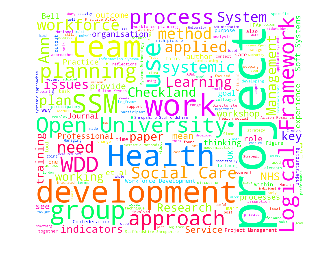

In [55]:
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#Convert all the required text into a single string here 
#and store them in word_string

#you can specify fonts, stopwords, background color and other options

wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(articleText)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [56]:
wordcloud

In [57]:
### With term frequency (tf-idf)
#removed to dev stuff/gensim.ipynb as it is unstable

In [58]:
## Discovering collaboration networks of a repository

In [59]:
# examine what is in pickles

In [60]:
import pickle
try:
    articles = pickle.load(open('data/all_articles_on1_1.pkl','rb'))
except (OSError,IOError) as e:
    print(e)

In [61]:
articles[0]['data'][0]

{u'authors': [u'Burgin, L. V.', u'Edelsten, L.', u'Aspden, R. M.'],
 u'contributors': [u'University of Aberdeen, School of Medical Sciences',
  u'University of Aberdeen, Medicine, Medical Sciences & Nutrition, Division Applied Medicine'],
 u'datePublished': u'2014-02',
 u'description': u'Copyright \xa9 2013 IPEM. Published by Elsevier Ltd. All rights reserved.Peer reviewedPostprin',
 u'doi': u'10.1016/j.medengphy.2013.11.002',
 u'fullText': u"  \nThe mechanical and material properties of elderly human articular \ncartilage subject to impact and slow loading \n \nRunning title: Impact loading and composition of human cartilage \n \nL.V. Burgin1, L. Edelsten2 and R.M. Aspden* \nMusculoskeletal Research Programme, School of Medicine & Dentistry, University of \nAberdeen, Aberdeen, UK. \n1Current address: Medical Technologies Innovation and Knowledge Centre, X102 Medical \nand Biological Engineering - University of Leeds, Leeds, LS2 9JT. UK. \nL.V.Burgin@leeds.ac.uk \n2Current email addres

This is the full metadata and fulltext in raw format ready to be analysed of this article:https://core.ac.uk/download/pdf/19787393.pdf

In [62]:
text = articles[0]['data'][0]['fullText']

In [63]:
import re
match = re.findall(r'[\w\.-]+@[\w\.-]+', text)

In [64]:
match

[u'L.V.Burgin@leeds.ac.uk',
 u'Lorna.ramsay@education.gsi.gov.uk',
 u'r.aspden@abdn.ac.uk']

Now do the same for all the aricles of repository 1

In [65]:
import pickle 
import re
def get_all_emails_of_repository(repoId):
    all_emails = []
    for page_pickle in range(1,10):
        try:
            articles = pickle.load(open('data/all_articles_on'+str(repoId)+'_'+str(page_pickle)+'.pkl','rb'))
            for page in range(0,len(articles)):
                for item in articles[page]['data']:
                    text = item['fullText']
                    article_id=item['id']
                    match = re.findall(r'[\w\.-]+@[\w\.-]+', text)
#                     print(match)
                    all_emails.append([article_id, match])
        except (OSError,IOError) as e:
            print(e)
    return all_emails

In [66]:
emails_of_1 = get_all_emails_of_repository(1)

In [67]:
emails_of_1

[[u'19787393',
  [u'L.V.Burgin@leeds.ac.uk',
   u'Lorna.ramsay@education.gsi.gov.uk',
   u'r.aspden@abdn.ac.uk']],
 [u'19787406', [u'david.mcghee@abdn.ac.uk']],
 [u'20327925', [u'j.mercer@abdn.ac.uk', u'michelle.murphy@abdn.ac.uk']],
 [u'20664118', [u'Sarah.Harris@igmm.ed.ac.uk.']],
 [u'20664131', [u'T.Gillingwater@ed.ac.uk.']],
 [u'20664054', [u'jiabao.he@abdn.ac.uk']],
 [u'20664371', []],
 [u'19888921', [u's.schwarzkopf@gmail.com']],
 [u'20664053',
  [u'marie.castellazzi@hutton.ac.uk',
   u'diana.feliciano@abdn.ac.uk',
   u'iain.brown@hutton.ac.uk']],
 [u'20664046', [u'Jill.Francis.1@city.ac.uk']],
 [u'20664363', [u'jukka.corander@helsinki.fi', u's.k.sheppard@swansea.ac.uk']],
 [u'19787395', [u'a.price@abdn.ac.uk']],
 [u'20443919', []],
 [u'20443926', [u'a.r.akisanya@abdn.ac.uk.']],
 [u'19506505', [u'j.hussein@abdn.ac.uk']],
 [u'19888922', [u'c.hesse@abdn.ac.uk']],
 [u'19888923', [u'y.hopf@abdn.ac.uk']],
 [u'19506513', [u'clare.allely@glasgow.ac.uk']],
 [u'19506506', [u'n.r.velaga@ii

Lets flatten the list

In [68]:
def flatten_list(unevenList):
    flat_list=[]
    for sublist in unevenList:
        aid=sublist[0]
        emails = sublist[1]
        for item in emails:
            flat_list.append([aid,item])
    return flat_list

In [69]:
email_of_1_flat = flatten_list(emails_of_1)
len(email_of_1_flat)

2936

In [70]:
email_of_1_flat[1:10]

[[u'19787393', u'Lorna.ramsay@education.gsi.gov.uk'],
 [u'19787393', u'r.aspden@abdn.ac.uk'],
 [u'19787406', u'david.mcghee@abdn.ac.uk'],
 [u'20327925', u'j.mercer@abdn.ac.uk'],
 [u'20327925', u'michelle.murphy@abdn.ac.uk'],
 [u'20664118', u'Sarah.Harris@igmm.ed.ac.uk.'],
 [u'20664131', u'T.Gillingwater@ed.ac.uk.'],
 [u'20664054', u'jiabao.he@abdn.ac.uk'],
 [u'19888921', u's.schwarzkopf@gmail.com']]

In [46]:
#how many authors from aberdeen's articles are from aberdeen?
abdn_ctn=0
for i in email_of_1_flat:
    if i[1].endswith("abdn.ac.uk"):
        abdn_ctn +=1
print(abdn_ctn,len(email_of_1_flat))

(1132, 2936)


### so about 50% of authors in articles in the Aberdeen repository are not from Aberdeen

In [72]:
import pandas as pd

Let's import a catalogue of all world domain of academic instituiotns and match it to authors

In [73]:
world_domains = pd.read_json('world_universities_and_domains.json')
world_domains.head()

,alpha_two_code,country,domain,name,web_page
0,US,United States,calbaptist.edu,California Baptist University,http://www.calbaptist.edu/
1,US,United States,stevenson.edu,Stevenson University,http://www.stevenson.edu/
2,US,United States,mbl.edu,Marine Biological Laboratory,http://www.mbl.edu/
3,US,United States,maryville.edu,Maryville University,http://www.maryville.edu/
4,US,United States,aii.edu,The Art Institutes,http://www.aii.edu/


In [74]:
#Create the frame with the emails

In [75]:
emails_df = pd.DataFrame.from_records(email_of_1_flat)
emails_df.head()

,0,1
0,19787393,L.V.Burgin@leeds.ac.uk
1,19787393,Lorna.ramsay@education.gsi.gov.uk
2,19787393,r.aspden@abdn.ac.uk
3,19787406,david.mcghee@abdn.ac.uk
4,20327925,j.mercer@abdn.ac.uk


We need to extract domain from each email:

In [76]:
def extract_domain(email):
    return email.split("@")[1]

In [77]:
#let's test:
extract_domain("mackenzie@abdn.ac.uk")

'abdn.ac.uk'

In [78]:
#now run it on all the frame
emails_df['domain']=emails_df.apply(lambda row: extract_domain(row[1]),axis=1)
emails_df.head()

,0,1,domain
0,19787393,L.V.Burgin@leeds.ac.uk,leeds.ac.uk
1,19787393,Lorna.ramsay@education.gsi.gov.uk,education.gsi.gov.uk
2,19787393,r.aspden@abdn.ac.uk,abdn.ac.uk
3,19787406,david.mcghee@abdn.ac.uk,abdn.ac.uk
4,20327925,j.mercer@abdn.ac.uk,abdn.ac.uk


Now for the extracted domain match it (join operation) with the known affiliation of this domain using our first frame

In [79]:
merged_domains = pd.merge(emails_df,world_domains , left_on='domain',right_on="domain")
merged_domains.head(10)

,0,1,domain,alpha_two_code,country,name,web_page
0,19787393,L.V.Burgin@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
1,18498901,T.R.A.Ensor@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
2,18498901,T.R.A.Ensor@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
3,17201917,n.alwan@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
4,177081,j.d.walley@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
5,30435804,r.m.wilkie@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
6,77052240,d.miller@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
7,77614526,pscplab@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
8,77614646,s.r.kingsbury@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/
9,30435935,d.g.jayne@leeds.ac.uk,leeds.ac.uk,GB,United Kingdom,University of Leeds,http://www.leeds.ac.uk/


In [130]:

merged_domains.columns = ['core_id', 'mail', 'domain','alpha_two_code', 'country', "name", "web"]


In [133]:
unique_domains = merged_domains.domain.unique()
unique_domains
domain_id_dict = {}
for domain in unique_domains:
    ids = merged_domains[merged_domains.domain==domain].core_id
    collaboration = merged_domains[merged_domains.core_id.isin(ids)].domain
    domain_id_dict[domain]=collaboration.values




{u'abdn.ac.uk': array([u'leeds.ac.uk', u'leeds.ac.uk', u'leeds.ac.uk', ...,
        u'columbia.edu', u'uit.no', u'mit.edu'], dtype=object),
 u'aber.ac.uk': array([u'aber.ac.uk', u'aber.ac.uk'], dtype=object),
 u'abertay.ac.uk': array([u'abdn.ac.uk', u'stir.ac.uk', u'abertay.ac.uk', u'abertay.ac.uk'], dtype=object),
 u'adelaide.edu.au': array([u'adelaide.edu.au'], dtype=object),
 u'asu.edu': array([u'lzu.edu.cn', u'lzu.edu.cn', u'asu.edu', u'asu.edu', u'asu.edu',
        u'asu.edu', u'asu.edu', u'asu.edu'], dtype=object),
 u'auckland.ac.nz': array([u'abdn.ac.uk', u'auckland.ac.nz', u'auckland.ac.nz',
        u'auckland.ac.nz', u'auckland.ac.nz', u'auckland.ac.nz'], dtype=object),
 u'bangor.ac.uk': array([u'abdn.ac.uk', u'abdn.ac.uk', u'abdn.ac.uk', u'abdn.ac.uk',
        u'abdn.ac.uk', u'bangor.ac.uk', u'bangor.ac.uk', u'bangor.ac.uk',
        u'bangor.ac.uk', u'bangor.ac.uk', u'bath.ac.uk', u'hw.ac.uk'], dtype=object),
 u'bath.ac.uk': array([u'abdn.ac.uk', u'abdn.ac.uk', u'abdn.ac.uk',

And now let's group by to find biggest instituions collaborating with Aberdeen:

In [82]:
# merged_domains.groupby(['domain']).agg(['count']).reset_index('count').sort_values(['count'], ascending=False)
count_frame = merged_domains.groupby(['domain']).count().sort_values([1],ascending=False)#.reset_index('count').sort_values(['count'], ascending=False)
count_frame.head(10)

,0,1,alpha_two_code,country,name,web_page
domain,,,,,,
abdn.ac.uk,1111,1111,1111,1111,1111,1111
ncl.ac.uk,66,66,66,66,66,66
ed.ac.uk,52,52,52,52,52,52
dundee.ac.uk,19,19,19,19,19,19
lshtm.ac.uk,17,17,17,17,17,17
ucl.ac.uk,14,14,14,14,14,14
kcl.ac.uk,13,13,13,13,13,13
cam.ac.uk,12,12,12,12,12,12
bham.ac.uk,10,10,10,10,10,10


In [83]:
# count_frame = count_frame.ix[:,0:1]
# count_frame['ddomain'] = count_frame.index
# count_frame.head(10)
print(count_frame.index)

Index([u'abdn.ac.uk', u'ncl.ac.uk', u'ed.ac.uk', u'dundee.ac.uk',
       u'lshtm.ac.uk', u'ucl.ac.uk', u'kcl.ac.uk', u'cam.ac.uk', u'bham.ac.uk',
       u'leeds.ac.uk',
       ...
       u'tongji.edu.cn', u'le.ac.uk', u'adelaide.edu.au', u'uchile.cl',
       u'ucd.ie', u'ucalgary.ca', u'uah.es', u'ua.pt', u'tum.de',
       u'queensu.ca'],
      dtype='object', name=u'domain', length=153)


## External author-collaborators over time

In [84]:
import pickle 
import re
def get_all_emails_with_time_of_repository(repoId):
    all_emails = []
    for page_pickle in range(1,10):
        try:
            articles = pickle.load(open('data/all_articles_on'+str(repoId)+'_'+str(page_pickle)+'.pkl','rb'))
            for page in range(0,len(articles)):
                for item in articles[page]['data']:
                    text = item['fullText']
                    article_id=item['id']
                    year=item['year']
                    match = re.findall(r'[\w\.-]+@[\w\.-]+', text)
#                     print(match)
                    all_emails.append([article_id, year,match])
        except (OSError,IOError) as e:
            print(e)
    return all_emails

In [85]:
def flatten_list(unevenList):
    flat_list=[]
    for sublist in unevenList:
        aid=sublist[0]
        y=sublist[1]
        emails = sublist[2]
        for item in emails:
            flat_list.append([aid,y,item])
    return flat_list

In [86]:
aberdeen_emails_with_years= get_all_emails_with_time_of_repository(1)

In [87]:
aberdeen_emails_with_years_flatten=flatten_list(aberdeen_emails_with_years)

In [88]:
aberdeen_df = pd.DataFrame.from_records(aberdeen_emails_with_years_flatten)
aberdeen_df.head()

,0,1,2
0,19787393,2014,L.V.Burgin@leeds.ac.uk
1,19787393,2014,Lorna.ramsay@education.gsi.gov.uk
2,19787393,2014,r.aspden@abdn.ac.uk
3,19787406,2014,david.mcghee@abdn.ac.uk
4,20327925,2014,j.mercer@abdn.ac.uk


In [89]:
aberdeen_df['domain']=aberdeen_df.apply(lambda row: extract_domain(row[2]),axis=1)
aberdeen_df.head()

,0,1,2,domain
0,19787393,2014,L.V.Burgin@leeds.ac.uk,leeds.ac.uk
1,19787393,2014,Lorna.ramsay@education.gsi.gov.uk,education.gsi.gov.uk
2,19787393,2014,r.aspden@abdn.ac.uk,abdn.ac.uk
3,19787406,2014,david.mcghee@abdn.ac.uk,abdn.ac.uk
4,20327925,2014,j.mercer@abdn.ac.uk,abdn.ac.uk


In [90]:
aberdeen_df.columns = ["articleId","year","author_email","author_domain"]
aberdeen_df['external']=aberdeen_df['author_domain']!='abdn.ac.uk'

aberdeen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 5 columns):
articleId        2936 non-null object
year             2936 non-null int64
author_email     2936 non-null object
author_domain    2936 non-null object
external         2936 non-null bool
dtypes: bool(1), int64(1), object(3)
memory usage: 94.7+ KB


In [91]:
# ab_gr_df = aberdeen_df.groupby(["year"]).count().sort(["year"],ascending=False)#.reset_index('count').sort_values(['count'], ascending=False)
ab_gr_df = aberdeen_df.groupby(["year","external"]).count()
ab_gr_df

articleId  author_email  author_domain
year external                                        
2001 True              2             2              2
2002 False             1             1              1
     True              2             2              2
2003 True              2             2              2
2004 False            15            15             15
     True              8             8              8
2005 False            10            10             10
     True             18            18             18
2006 False            46            46             46
     True             72            72             72
2007 False            87            87             87
     True            140           140            140
2008 False            68            68             68
     True            115           115            115
2009 False            60            60             60
     True            119           119            119
2010 False            37            37             37
     True             89            89             89
2011 False            72            72             72
     True            167           167            167
2012 False           100           100            100
     True            112           112            112
2013 False            91            91             91
     True            120           120            120
2014 False            49            49             49
     True             64            64             64
2015 False           195           195            195
     True            365           365            365
2016 False           244           244            244
     True            382           382            382
2017 False            36            36             36
     True             48            48             48

In [155]:
ab_gr_df['articleId']

year  external
2001  True          2
2002  False         1
      True          2
2003  True          2
2004  False        15
      True          8
2005  False        10
      True         18
2006  False        46
      True         72
2007  False        87
      True        140
2008  False        68
      True        115
2009  False        60
      True        119
2010  False        37
      True         89
2011  False        72
      True        167
2012  False       100
      True        112
2013  False        91
      True        120
2014  False        49
      True         64
2015  False       195
      True        365
2016  False       244
      True        382
2017  False        36
      True         48
Name: articleId, dtype: int64

In [156]:
## Collaborators across universities

In [165]:
emails_of_repository=dict()
cached_repos=[1,86,39,136,48]
for i in cached_repos:
    emails_of_repository[i]=get_all_emails_of_repository(i)

In [159]:
emails_of_repository

[]

In [ ]:
## Combining important terms with external collaboration networks
### What are the topics that gets the most external authors ?

[None]

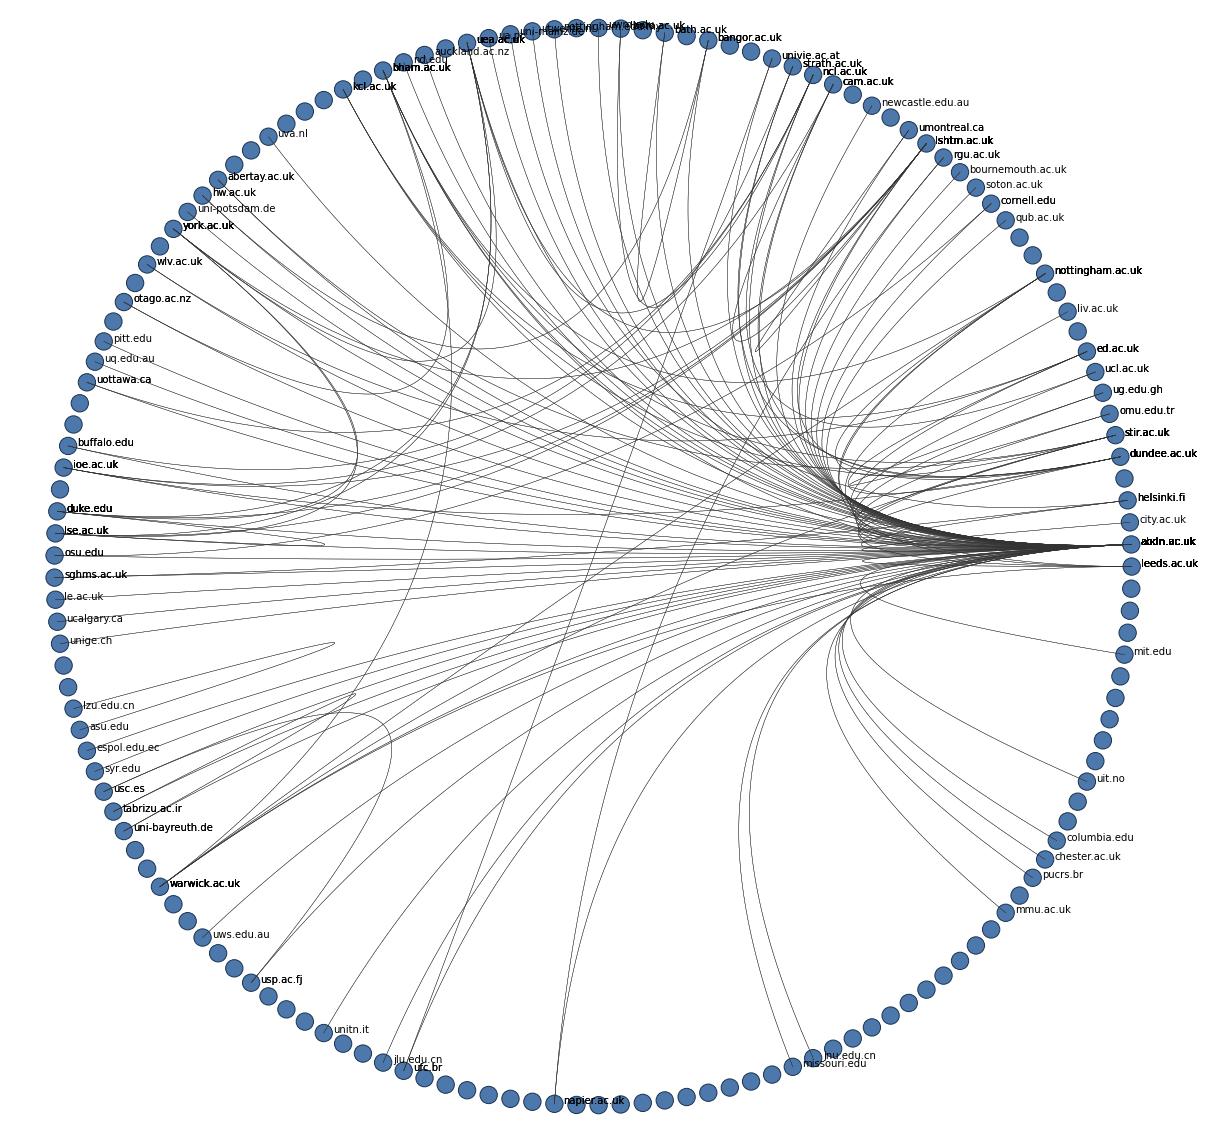

In [212]:
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import sys

domain_list= list(unique_domains)
fig, ax = plt.subplots(figsize=(30, 20))
plt.axis('off')

npoints = len(domain_list)

# Calculate the xy coords for each point on the circle
s = 2 * np.pi / npoints
verts = np.zeros((npoints, 2))
for i in np.arange(npoints):
    angle = s * i
    x = npoints * np.cos(angle)
    y = npoints * np.sin(angle)
    verts[i] = [x, y]
    

# Plot the Bezier curves
numbers = [i for i in xrange(npoints)]
bezier_path = np.arange(0, 1.01, 0.01)

x, y = verts.T
ax.scatter(x, y, marker='o', s=300, c='#4D78AC', edgecolor='#1D3552')

for a,b in itertools.product(domain_list, repeat=2):
    if a == b:
        continue
       
    if a in domain_id_dict[b]:
       
        x1y1 = x1, y1 = verts[domain_list.index(a)]
        x2y2 = x2, y2 = verts[domain_list.index(b)]

        xbyb = xb, yb = [0, 0]

        # Compute and store the Bezier curve points
        x = (1 - bezier_path)** 2 * x1 + 2 * (1 - bezier_path) * bezier_path * xb + bezier_path** 2 * x2
        y = (1 - bezier_path)** 2 * y1 + 2 * (1 - bezier_path) * bezier_path * yb + bezier_path** 2 * y2
        ax.plot(x, y, 'k-', linewidth=0.4, c='#333333')
#        if (a=="abdn.ac.uk"):
        ax.annotate(a, xy = verts[domain_list.index(a)], xytext = (+10, 0), textcoords = 'offset points')
        


ax.set_xlim(-npoints - 5, npoints + 6)
ax.set_ylim(-npoints - 5, npoints + 6)
ax.set(aspect=1)

In [135]:
node_color=['rgba(0,51,181, 0.85)' for d in domain_id_dict]
line_color=['#FFFFFF'  for d in domain_id_dict]
edge_colors=['#d4daff','#84a9dd', '#5588c8', '#6d8acf']

In [137]:
Xn=[layt[k][0] for k in range(len(domain_id_dict))]
Yn=[layt[k][1] for k in range(len(domain_id_dict))]

NameError: name 'layt' is not defined